# Visualizing Latent dimesnions

tensor([0.9838, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0101],
       device='cuda:0')
tensor([0.9838, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0101],
       device='cuda:0')
tensor([0.9544, 1.0000, 1.0000, 1.0000, 1.0000, 1.0011, 1.0000, 1.0000, 1.0728],
       device='cuda:0')
tensor([0.9544, 1.0000, 1.0000, 1.0000, 1.0000, 1.0011, 1.0000, 1.0000, 1.0728],
       device='cuda:0')
tensor([0.9851, 0.9683, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0196, 1.0694],
       device='cuda:0')
tensor([0.9851, 0.9683, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0196, 1.0694],
       device='cuda:0')
tensor([0.9915, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0022, 1.0106],
       device='cuda:0')
tensor([0.9915, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0022, 1.0106],
       device='cuda:0')


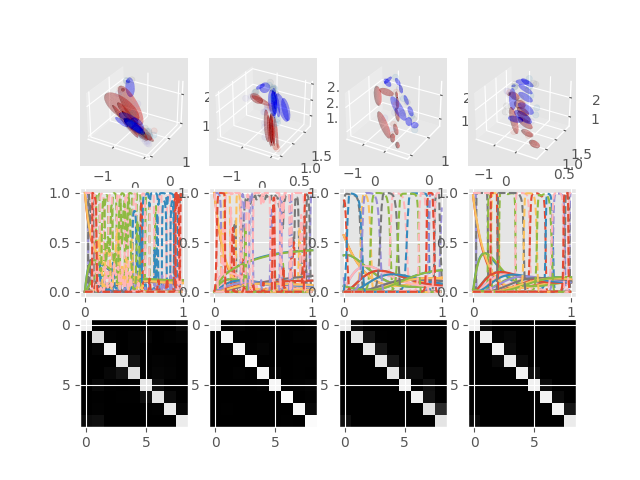

In [4]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from mild_hri import vae
from mild_hri.dataloaders import *

import pbdlib_torch as pbd_torch

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = '../../logs/2023/bp_hh_20hz/v1_0/diaghmm_z3h9/trial1/models/0070.pth'
ckpt = torch.load(ckpt_path)
args_ckpt = ckpt['args']
args_ckpt.latent_dim = 3
args_ckpt.hidden_sizes = [40, 20]
args_ckpt.downsample = 0.2
args_ckpt.window_size = 5

model = getattr(vae, args_ckpt.model)(**(args_ckpt.__dict__)).to(device)
model.load_state_dict(ckpt['model'])
model.eval()
z_dim = model.latent_dim

# if args_ckpt.dataset == 'buetepage_pepper':
# 	dataset = dataloaders.buetepage.PepperWindowDataset
# elif args_ckpt.dataset == 'buetepage':
dataset = buetepage.HHWindowDataset
# TODO: Nuitrack

ssm = ckpt['ssm']

test_dataset = dataset(os.path.join('../../',args_ckpt.src), train=False, window_length=args_ckpt.window_size, downsample=args_ckpt.downsample)
actions = ['Hand Wave', 'Hand Shake', 'Rocket Fistbump', 'Parachute Fistbump']

fig = plt.figure()
ax_dists = []
ax_alpha= [] 
ax_trans = []
for i in range(4):
	ax_dists.append(fig.add_subplot(3, 4, i+1, projection='3d'))
	ax_alpha.append(fig.add_subplot(3, 4, 4+i+1))
	ax_trans.append(fig.add_subplot(3, 4, 8+i+1))
actidx = np.hstack(test_dataset.actidx - np.array([0,1]))
for a in actidx:
	x, label = test_dataset[a]
	seq_len = x.shape[0]
	dims_h = model.input_dim
	x = torch.Tensor(x).to(device)
	x_h = x[:, :dims_h]
	x_r = x[:, dims_h:]
	
	zh_post = model(x_h, dist_only=True)
	zr_post = model(x_r, dist_only=True)
	ax_dists[label].scatter3D(zh_post.mean[::20, 0].detach().cpu().numpy(), zh_post.mean[::20, 1].detach().cpu().numpy(), zh_post.mean[::20, 2].detach().cpu().numpy(), 'r.', alpha=0.1)
	ax_dists[label].scatter3D(zr_post.mean[::20, 0].detach().cpu().numpy(), zr_post.mean[::20, 1].detach().cpu().numpy(), zr_post.mean[::20, 2].detach().cpu().numpy(), 'b.', alpha=0.1)

	alpha, _, _, _, _ = ssm[label].compute_messages(marginal=[], sample_size=seq_len)
	alpha_h, _, _, _, _ = ssm[label].compute_messages(demo=zh_post.mean, marginal=slice(0, z_dim))
	ax_alpha[label].plot(np.linspace(0, 1, seq_len), alpha.T.detach().cpu().numpy(), linestyle='-')
	ax_alpha[label].plot(np.linspace(0, 1, seq_len), alpha_h.T.detach().cpu().numpy(), linestyle='--')

	ax_trans[label].imshow(np.tile(ssm[label].Trans[..., None].detach().cpu().numpy(), (1,1,3)))#.detach().cpu().numpy())
	
	for i in range(ssm[label].nb_states):
		pbd_torch.plot_gauss3d(ax_dists[label], ssm[label].mu[i, :3].detach().cpu().numpy(), ssm[label].sigma[i, :3, :3].detach().cpu().numpy(),
					color='red', alpha=0.1)
		pbd_torch.plot_gauss3d(ax_dists[label], ssm[label].mu[i, z_dim:z_dim+3].detach().cpu().numpy(), ssm[label].sigma[i, z_dim:z_dim+3, z_dim:z_dim+3].detach().cpu().numpy(),
					color='blue', alpha=0.1)
		
	# break
